In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("amazon_reviews.csv", sep=",")

df.head()   

df["reviewText"] = df["reviewText"].str.lower()
df["reviewText"]

#Punctuations
df["reviewText"] = df["reviewText"].str.replace(r'[^\w\s]', " ", regex=True)
df["reviewText"]



0                                              no issues 
1       purchased this for my device  it worked as adv...
2       it works as expected  i should have sprung for...
3       this think has worked out great had a diff  br...
4       bought it with retail packaging  arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable  it ...
4913    good amount of space for the stuff i want to d...
4914    i ve heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

In [3]:
#Numbers
df["reviewText"] = df["reviewText"].str.replace(r'\d', " ", regex=True)
df["reviewText"] 



0                                              no issues 
1       purchased this for my device  it worked as adv...
2       it works as expected  i should have sprung for...
3       this think has worked out great had a diff  br...
4       bought it with retail packaging  arrived legit...
                              ...                        
4910    i bought this sandisk   gb class    to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable  it ...
4913    good amount of space for the stuff i want to d...
4914    i ve heard bad things about this   gb micro sd...
Name: reviewText, Length: 4915, dtype: object

In [4]:
#Stopwords
import nltk
#nltk.download('stopwords')
sw = stopwords.words("english")
df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))


In [5]:
#Rare words
temp_df = pd.Series(" ".join(df["reviewText"]).split()).value_counts()

drops = temp_df[temp_df <= 1]

df["reviewText"] = df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))


In [6]:
temp_df

card           4721
phone          1782
gb             1771
works          1586
great          1481
               ... 
discovering       1
progressing       1
ownership         1
bins              1
sk                1
Name: count, Length: 7511, dtype: int64

In [7]:

#Tokenization
#nltk.download("punkt_tab")

df["reviewText"].apply(lambda x: TextBlob(x).words).head()


0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, great, gb, card, went, south, ...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

In [8]:

#Lemmatization 
# kelimeleri köklerine ayırma işlemi
#nltk.download("wordnet")

df["reviewText"] = df["reviewText"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [9]:

# Terimlerin Frekansları

tf = df["reviewText"].apply(lambda x: pd.Series(str(x).split(" ")).value_counts()).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
#tf.sort_values("tf", ascending=False)



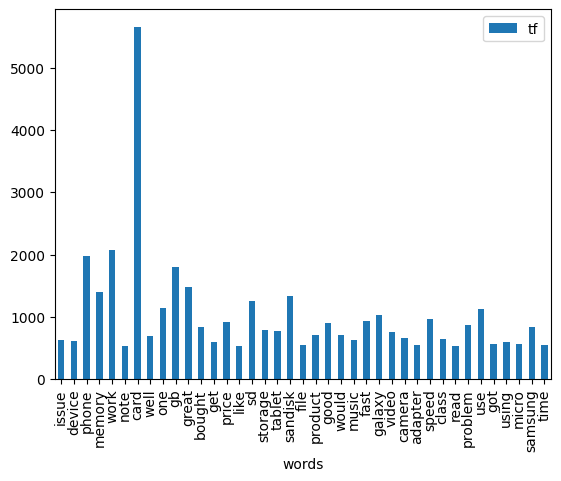

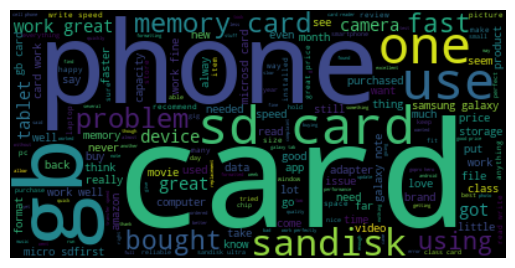

In [10]:

#Barplot
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

#Word Clout
text = " ".join(i for i in df["reviewText"])

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()




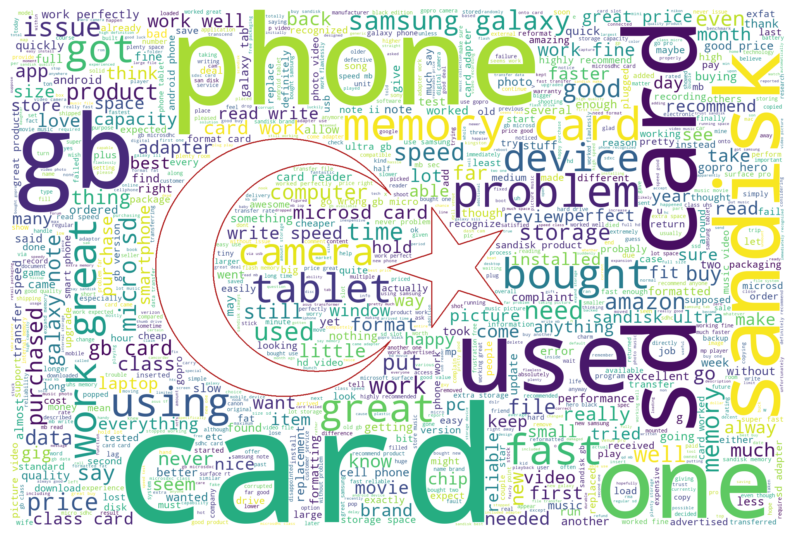

In [11]:


tr_mask = np.array(Image.open("tr.png"))

wc = WordCloud(background_color="white",
               max_words=1000,
               mask=tr_mask,
               contour_width=3,
               contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10, 10])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
#WordCloud.to_file("tr-output.png")



In [12]:

# Sentiment Analysis - Duygu Analizi
df["reviewText"].head()

#nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [13]:
sia.polarity_scores("I liked this music but it is not good another one")

{'neg': 0.239, 'neu': 0.615, 'pos': 0.146, 'compound': -0.298}

In [14]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0    0.0000
1    0.0000
2    0.4019
3    0.9231
4    0.8591
5    0.0000
6    0.8678
7    0.7351
8    0.0000
9    0.9167
Name: reviewText, dtype: float64

In [15]:
df["polarity_scores"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [16]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'day_diff',
       'helpful_yes', 'total_vote', 'polarity_scores'],
      dtype='object')

In [17]:
df["polarity_scores"]

0       0.0000
1       0.0000
2       0.4019
3       0.9231
4       0.8591
         ...  
4910    0.0772
4911    0.1761
4912    0.8481
4913    0.6908
4914    0.0516
Name: polarity_scores, Length: 4915, dtype: float64

In [18]:
df[(df["polarity_scores"] > 0) & (df["overall"] < 2)]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_scores
38,A1FKE13D77L3Y3,B007WTAJTO,Abraham Arturo Meza Marin,"[0, 0]",bougth micro sd card got kingston tell sandisk...,1.0,Stop working after 1 year,1361232000,2013-02-19,657,0,0,0.9606
177,A2VBZVFBSIOMS3,B007WTAJTO,"Amazon Customer ""Christian""","[0, 0]",use sdxc card gb card unreadable arrival pc sa...,1.0,Dead on arrival,1369180800,2013-05-22,565,0,0,0.7650
213,A3KEFFVJMUG0RY,B007WTAJTO,Amazon Customer,"[0, 0]",used sandisk photography course went time new ...,1.0,Never again SanDisk,1361232000,2013-02-19,657,0,0,0.4215
217,ARL6YY38UY9B2,B007WTAJTO,Amazon Customer,"[0, 0]",bought card gb sandisk phone right gift friend...,1.0,I'm not sure I can recommend this,1356393600,2012-12-25,713,0,0,0.9081
295,A242GRU73R7VVV,B007WTAJTO,Amazon Customer,"[0, 2]",card got hot almost crazy card somewhere else ...,1.0,stay away,1361750400,2013-02-25,651,0,2,0.4201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4718,A1II1343KW7I05,B007WTAJTO,Vicente Santorsola,"[0, 0]",acquired card month ago use phone samsung gala...,1.0,Very bad card,1370217600,2013-03-06,642,0,0,0.9328
4847,A1UHLKBYQU4FV7,B007WTAJTO,"Woody ""woodman""","[1, 1]",purchased galaxie phone fit work much else say...,1.0,It stoppd working!,1359331200,2013-01-28,679,1,1,0.3400
4867,A12P4PSWWXUYA0,B007WTAJTO,xplics,"[3, 5]",buyer beware card unreadable get go luck amazo...,1.0,Like others reviewed not that great of a card.,1348012800,2012-09-19,810,3,5,0.5719
4892,A2SVI2JSSMA3PS,B007WTAJTO,Zackariah Zielieke,"[0, 1]",hello great card great price plenty speed work...,1.0,It worked good until return policy was out,1388016000,2013-12-26,347,0,1,0.9814


In [19]:
df[(df["overall"] < 3)]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_scores
32,AF24M1HKIZ7QC,B007WTAJTO,"Abdulrahman J. Alrashed ""dr34m3r""","[0, 0]",bought sandisk gb microsd used galaxy note gal...,1.0,Bought 2 :) Died,1375488000,2013-03-08,640,0,0,-0.4404
38,A1FKE13D77L3Y3,B007WTAJTO,Abraham Arturo Meza Marin,"[0, 0]",bougth micro sd card got kingston tell sandisk...,1.0,Stop working after 1 year,1361232000,2013-02-19,657,0,0,0.9606
43,A1X1FX3NSOFCT3,B007WTAJTO,"Abused Commuter ""abused_commuter""","[0, 1]",ordered galaxy lasted month broke accessible s...,1.0,Beware... goes bad and takes your pics with it,1374278400,2013-07-20,506,0,1,-0.7506
49,A2RJ7DAL63MN1F,B007WTAJTO,Ace of Sevens,"[0, 0]",used month phone decided quit mounting lost pi...,2.0,Worked for a few months,1391126400,2014-01-31,311,0,0,-0.6124
108,A28CTDM7OP0RAR,B007WTAJTO,Alan,"[0, 0]",work actual r w speed mb even class sandisk ba...,2.0,Painfully slow,1395705600,2014-03-25,258,0,0,0.4215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4867,A12P4PSWWXUYA0,B007WTAJTO,xplics,"[3, 5]",buyer beware card unreadable get go luck amazo...,1.0,Like others reviewed not that great of a card.,1348012800,2012-09-19,810,3,5,0.5719
4891,A3DJS9HZ1FPANU,B007WTAJTO,Zach S.,"[1, 1]",fastest microsd card tested unfortunately died...,1.0,Fast but short-lived,1363910400,2013-03-22,626,1,1,-0.7184
4892,A2SVI2JSSMA3PS,B007WTAJTO,Zackariah Zielieke,"[0, 1]",hello great card great price plenty speed work...,1.0,It worked good until return policy was out,1388016000,2013-12-26,347,0,1,0.9814
4904,A176OYR7KGC1PC,B007WTAJTO,zhengziying,"[1, 2]",put important data use permanent storage archi...,1.0,failed in 1.5 months,1354665600,2012-05-12,940,1,2,-0.9042


In [20]:
# Sentiment modeling
# -> Future Engineering
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["santiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [21]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_scores,santiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.0,Four Stars,1406073600,2014-07-23,138,0,0,0.0000,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.0000,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,0.4019,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked great gb card went south month on...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.9231,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.0,best deal around,1373673600,2013-07-13,513,0,0,0.8591,pos


In [22]:
df["santiment_label"].value_counts()

santiment_label
pos    3939
neg     976
Name: count, dtype: int64

In [23]:
df.groupby("santiment_label").agg({"overall":"mean"})

,overall
santiment_label,
neg,4.085041
pos,4.712110


In [24]:
# positive =1, negative =0
df["santiment_label"] = LabelEncoder().fit_transform(df["santiment_label"])

In [25]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_scores,santiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",issue,4.0,Four Stars,1406073600,2014-07-23,138,0,0,0.0000,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",purchased device worked advertised never much ...,5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.0000,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",work expected higher capacity think made bit e...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0,0.4019,1
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",think worked great gb card went south month on...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.9231,1
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",bought retail packaging arrived legit envelope...,5.0,best deal around,1373673600,2013-07-13,513,0,0,0.8591,1


In [26]:
y = df["santiment_label"]
X = df["reviewText"]

In [27]:
# Count Vectors 
# kelime frekansları
# - metindeki kelimeleri ilk olarak eşsiz hale getirdi. Metindeki bütün kelimeleri tek bir halde dizi haline getirdi.
# - Ardından bu kelimelerin cümleler halinde kaç tane içerdiğini gösterecek şekilde matrix formuna getirildi.
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [29]:
# word frekans
vectorizer = CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

In [30]:
X_c.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 2, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [31]:
# n-gram frekans
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X_n = vectorizer2.fit_transform(corpus)
vectorizer2.get_feature_names_out()

array(['and this', 'document is', 'first document', 'is the', 'is this',
       'second document', 'the first', 'the second', 'the third',
       'third one', 'this document', 'this is', 'this the'], dtype=object)

In [32]:
X_n.toarray()

array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]])

In [33]:
vectorizer = CountVectorizer()

In [34]:
X_count = vectorizer.fit_transform(X)
vectorizer.get_feature_names_out()[10:15]

array(['access', 'accessed', 'accessible', 'accessing', 'accessory'],
      dtype=object)

In [35]:
X_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(4915, 3551))

In [36]:
# TF - IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
tf_idf_word_vectorizer = TfidfVectorizer()
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)

In [38]:
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3))
X_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(X)

In [39]:
# Sentiment Modeling
# 1. Text Preprocessing
# 2. Text Visualization
# 3. Sentiment Analysis
# 4. Feature Engineering
# 5. Sentiment Modeling

In [40]:
# logistic regression

In [41]:
log_model = LogisticRegression().fit(X_tf_idf_word, y)

# model doğruluğu

In [42]:
cross_val_score(log_model, 
               X_tf_idf_word,
               y,
               scoring="accuracy",
               cv=5).mean()

np.float64(0.8368260427263479)

In [67]:
new_review = pd.Series("this product is great")

In [44]:
new_review = TfidfVectorizer().fit(X).transform(new_review)

In [45]:
log_model.predict(new_review)

array([1])

In [70]:
def log_model_predict_tf_idf(new_review, X):
    new = str(new_review).lower()
    new = str(new).replace(r'[^\w\s]', " ")
    new = str(new).replace(r'\d', " ")
    new = " ".join(x for x in str(new).split() if x not in sw)
    new = " ".join(Word(x).lemmatize() for x in new.split())
    new = pd.Series(new)
    new = TfidfVectorizer().fit(X).transform(new)
    predict = log_model.predict(new)
    return predict

In [72]:
a = log_model_predict(new_review, X)
a

array([1])

In [73]:
# Random Forest

In [75]:
rf_model = RandomForestClassifier().fit(X_count, y)
# burada X_count bizim kelime frekansımız -> Count Vectors


In [76]:
cross_val_score(rf_model, X_count, y, cv=5, n_jobs=-1).mean()

np.float64(0.8476093591047812)

In [77]:
#TF-IDF word-level
rf_model = RandomForestClassifier().fit(X_tf_idf_word, y)

In [78]:
cross_val_score(rf_model, X_tf_idf_word, y, cv=5, n_jobs=-1).mean()

np.float64(0.8327568667344863)

In [79]:
#TF-IDF ngram
rf_model = RandomForestClassifier().fit(X_tf_idf_ngram, y)

In [80]:
cross_val_score(rf_model, X_tf_idf_ngram, y, cv=5, n_jobs=-1).mean()

np.float64(0.7859613428280773)

In [81]:
# Hiperparametre Optimizasyonu 
rf_model = RandomForestClassifier(random_state=17)

In [82]:
rf_params = {"max_depth": [8, 10],
            "max_features": [7, "auto"],
            "min_samples_split": [2, 5, 8],
            "n_estimators": [100, 200]}

In [83]:
rf_best_grid = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=1).fit(X_count, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~

In [84]:
rf_best_grid.best_params_

{'max_depth': 8,
 'max_features': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

In [85]:
rf_final = rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count, y)

In [86]:
cross_val_score(rf_final, X_count, y, cv=5, n_jobs=-1).mean()

np.float64(0.8014242115971516)